<a href="https://colab.research.google.com/github/Indukurivigneshvarma/Deep_Learning/blob/main/Computer_Vision/StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install torch torchvision tqdm matplotlib --quiet

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [18]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim=128, w_dim=128, n_layers=4):
        super().__init__()
        layers = []
        dim = z_dim
        for _ in range(n_layers):
            layers += [nn.Linear(dim, w_dim), nn.LeakyReLU(0.2)]
            dim = w_dim
        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        z = z / (z.norm(dim=1, keepdim=True) + 1e-8)
        return self.mapping(z)

In [19]:
class AdaIN(nn.Module):
    def __init__(self, w_dim, channels):
        super().__init__()
        self.fc_scale = nn.Linear(w_dim, channels)
        self.fc_bias = nn.Linear(w_dim, channels)

    def forward(self, x, w):
        mean_x = x.mean(dim=[2,3], keepdim=True)
        std_x = x.std(dim=[2,3], keepdim=True) + 1e-8
        x = (x - mean_x) / std_x
        scale = self.fc_scale(w).view(-1, x.size(1), 1, 1)
        bias = self.fc_bias(w).view(-1, x.size(1), 1, 1)
        return scale * x + bias

In [20]:
class StyledConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, w_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.adain = AdaIN(w_dim, out_ch)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        x = self.conv(x)
        x = self.adain(x, w)
        return self.lrelu(x)

In [21]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, w_dim=128, base_ch=64):
        super().__init__()
        self.mapping = MappingNetwork(z_dim, w_dim)
        self.const_input = nn.Parameter(torch.randn(1, base_ch*4, 4, 4))
        self.layers = nn.ModuleList([
            StyledConvBlock(base_ch*4, base_ch*2, w_dim),
            StyledConvBlock(base_ch*2, base_ch, w_dim),
            StyledConvBlock(base_ch, 3, w_dim)
        ])

    def forward(self, z):
        w = self.mapping(z)
        x = self.const_input.repeat(z.size(0), 1, 1, 1)
        for layer in self.layers[:-1]:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
            x = layer(x, w)
        x = torch.tanh(self.layers[-1](x, w))
        return x

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4), nn.Flatten()
        )
    def forward(self, x): return self.model(x)

In [23]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.CIFAR10(root="data", download=True, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [24]:
gen = Generator().to(device)
disc = Discriminator().to(device)
opt_g = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(disc.parameters(), lr=4e-4, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

real_label = 0.9
fake_label = 0.1

In [25]:
epochs = 10
for epoch in range(epochs):
    for real, _ in loader:
        real = real.to(device)
        bs = real.size(0)

        z = torch.randn(bs, 128).to(device)
        fake = gen(z).detach()

        d_real = disc(real)
        d_fake = disc(fake)

        loss_d_real = criterion(d_real, torch.full_like(d_real, real_label))
        loss_d_fake = criterion(d_fake, torch.full_like(d_fake, fake_label))
        loss_d = (loss_d_real + loss_d_fake) / 2

        opt_d.zero_grad()
        loss_d.backward()
        opt_d.step()

        z = torch.randn(bs, 128).to(device)
        fake = gen(z)
        d_fake = disc(fake)
        loss_g = criterion(d_fake, torch.full_like(d_fake, real_label))

        opt_g.zero_grad()
        loss_g.backward()
        opt_g.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {loss_d.item():.3f} | G Loss: {loss_g.item():.3f}")

Epoch 1/10 | D Loss: 0.334 | G Loss: 2.091
Epoch 2/10 | D Loss: 0.329 | G Loss: 2.059
Epoch 3/10 | D Loss: 0.329 | G Loss: 2.061
Epoch 4/10 | D Loss: 0.329 | G Loss: 2.066
Epoch 5/10 | D Loss: 0.329 | G Loss: 2.021
Epoch 6/10 | D Loss: 0.329 | G Loss: 2.076
Epoch 7/10 | D Loss: 0.329 | G Loss: 2.107
Epoch 8/10 | D Loss: 0.328 | G Loss: 2.107
Epoch 9/10 | D Loss: 0.329 | G Loss: 2.148
Epoch 10/10 | D Loss: 0.328 | G Loss: 2.063


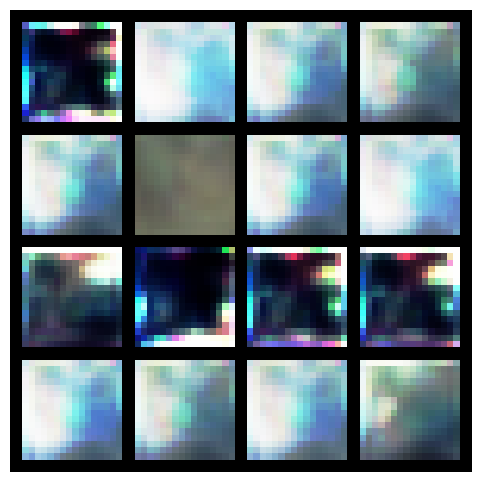

In [26]:
z = torch.randn(16, 128).to(device)
with torch.no_grad():
    fake_imgs = gen(z).cpu() * 0.5 + 0.5

grid = utils.make_grid(fake_imgs, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()